<a href="https://colab.research.google.com/github/elarada/sample-resume/blob/main/user_persona_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
os.chdir('/content/drive/MyDrive/Commerce')
os.getcwd()

'/content/drive/MyDrive/Commerce'

In [ ]:
import pandas as pd
from collections import Counter
import plotly.graph_objects as go
import numpy as np
import pytz
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm


## 📌데이터정리

In [ ]:
click_stream_df = pd.read_csv('click_stream_cleaned.csv')

In [ ]:
transaction_df = pd.read_csv('transactions_cleaned.csv')

In [ ]:
customer_df = pd.read_csv('customer_cleaned.csv')

In [ ]:
product_df =  pd.read_csv('product_cleaned.csv')

In [ ]:
# 1. 문자열을 datetime으로 변환 (UTC 기준, tz-aware로 만들기)
click_stream_df['event_time'] = pd.to_datetime(click_stream_df['event_time'], utc=True)

# 2. 인도네시아 시간 (Asia/Jakarta)로 변환
click_stream_df['event_time'] = click_stream_df['event_time'].dt.tz_convert('Asia/Jakarta')


In [ ]:
transaction_df['created_at'] = pd.to_datetime(transaction_df['created_at'], utc=True)

transaction_df['created_at'] = transaction_df['created_at'].dt.tz_convert('Asia/Jakarta')

In [ ]:
!pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 58.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib

In [ ]:
transaction_df = transaction_df[
    (transaction_df['created_at'] >= '2021-07-01') &
    (transaction_df['created_at'] <= '2022-08-01')
]

In [ ]:
click_stream_df = click_stream_df[
    (click_stream_df['event_time'] >= '2021-07-01') &
    (click_stream_df['event_time'] <= '2022-08-01')
]

In [ ]:
print(transaction_df['created_at'].max())

2022-07-31 23:59:43.042682+07:00


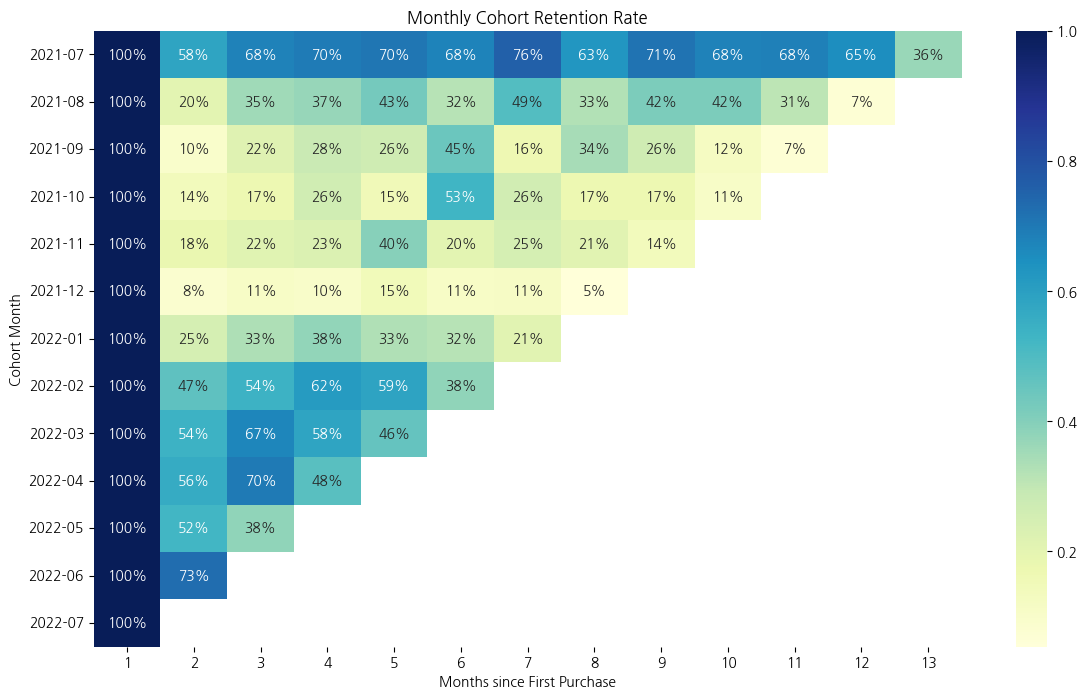

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 날짜 처리
transaction_df['created_at'] = pd.to_datetime(transaction_df['created_at'], utc=True)
transaction_df['created_at'] = transaction_df['created_at'].dt.tz_convert('Asia/Jakarta')

# 2. Cohort 기준 정의 (월 단위)
transaction_df['order_month'] = transaction_df['created_at'].dt.to_period('M')
cohort_df = transaction_df.groupby('customer_id')['order_month'].min().reset_index()
cohort_df.columns = ['customer_id', 'cohort_month']

# 3. 원본과 병합
transaction_df = pd.merge(transaction_df, cohort_df, on='customer_id')

# 4. Cohort Index 생성 (해당 고객이 유입 후 몇 개월 차인지)
transaction_df['cohort_index'] = (
    (transaction_df['order_month'].dt.year - transaction_df['cohort_month'].dt.year) * 12
    + (transaction_df['order_month'].dt.month - transaction_df['cohort_month'].dt.month)
) + 1  # 1부터 시작

# 5. Cohort 분석 테이블 (고객 수 기준)
cohort_pivot = (
    transaction_df
    .groupby(['cohort_month', 'cohort_index'])['customer_id']
    .nunique()
    .unstack(1)
)

# 6. 퍼센트화 (리텐션율)
cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0).round(3)

# 7. 시각화 (히트맵)
plt.figure(figsize=(14, 8))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='YlGnBu')
plt.title('Monthly Cohort Retention Rate')
plt.xlabel('Months since First Purchase')
plt.ylabel('Cohort Month')
plt.show()

In [ ]:
# 고객별 첫 구매일과 총 구매액
first_purchase = transaction_df.groupby('customer_id').agg(
    first_purchase_date=('created_at', 'min'),
    first_total_amount=('total_amount', 'sum')
).reset_index()


In [ ]:
# 수익 기준으로 코호트 분류 (4분위 기준)
first_purchase['revenue_cohort'] = pd.qcut(first_purchase['first_total_amount'], q=4, labels=['Low', 'Mid', 'High', 'Top'])

In [ ]:
# 중복 컬럼 제거 후 병합
transaction_df = transaction_df.drop(columns=['first_purchase_date', 'revenue_cohort'], errors='ignore')

transaction_df = transaction_df.merge(
    first_purchase[['customer_id', 'first_purchase_date', 'revenue_cohort']],
    on='customer_id',
    how='left'
)


In [ ]:
#tz 정보 제거 후 월 단위로 변환
transaction_df['cohort_month'] = transaction_df['first_purchase_date'].dt.tz_localize(None).dt.to_period('M').dt.to_timestamp()
transaction_df['event_month'] = transaction_df['created_at'].dt.tz_localize(None).dt.to_period('M').dt.to_timestamp()

# 코호트 인덱스: 가입 이후 몇 개월차인지
transaction_df['cohort_index'] = (
    (transaction_df['event_month'].dt.year - transaction_df['cohort_month'].dt.year) * 12 +
    (transaction_df['event_month'].dt.month - transaction_df['cohort_month'].dt.month)
)


In [ ]:
# 고객별로 고유하게 counting (중복 제거)
cohort_pivot = transaction_df.groupby(['revenue_cohort', 'cohort_month', 'cohort_index'])['customer_id'] \
                             .nunique().reset_index()

# 피벗 테이블로 변경
retention_table = cohort_pivot.pivot_table(
    index=['revenue_cohort', 'cohort_month'],
    columns='cohort_index',
    values='customer_id'
)

# 리텐션율 계산 (%)
retention_rate = retention_table.divide(retention_table.iloc[:,0], axis=0).round(3) * 100


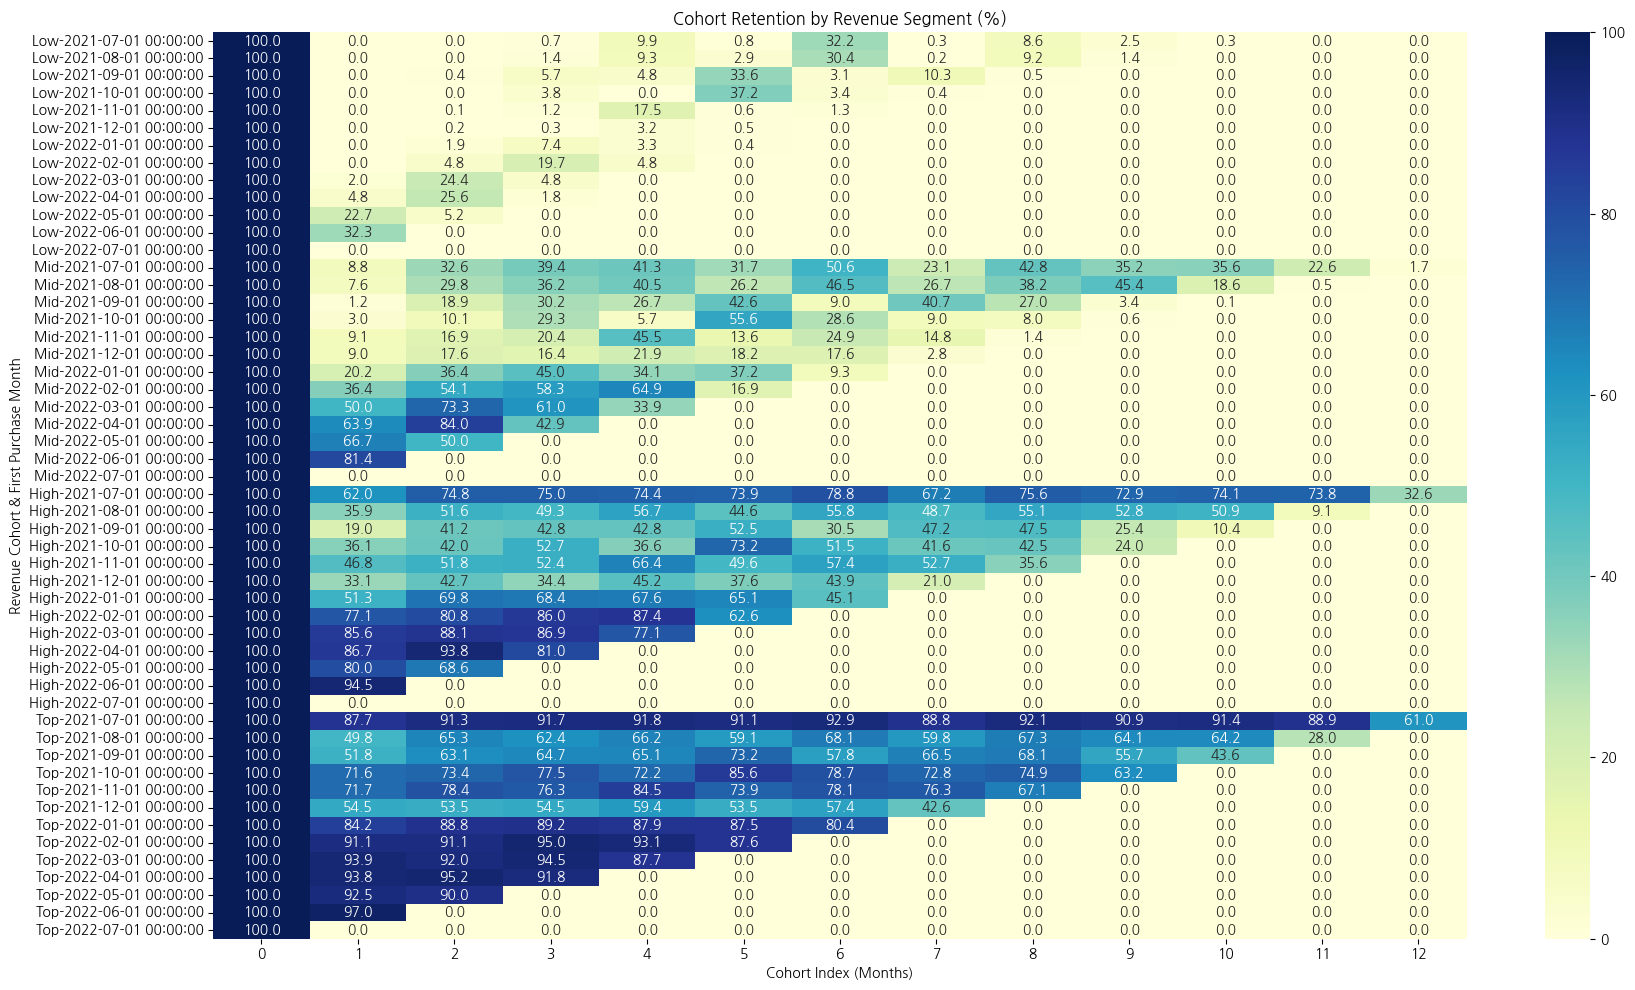

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))
sns.heatmap(retention_rate, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Cohort Retention by Revenue Segment (%)')
plt.xlabel('Cohort Index (Months)')
plt.ylabel('Revenue Cohort & First Purchase Month')
plt.tight_layout()
plt.show()


In [ ]:
# 월별 ARPU 계산
arpu = transaction_df.groupby(['revenue_cohort', 'cohort_month', 'cohort_index'])['total_amount'].sum()
arpu_count = transaction_df.groupby(['revenue_cohort', 'cohort_month', 'cohort_index'])['customer_id'].nunique()
arpu_result = (arpu / arpu_count).unstack()


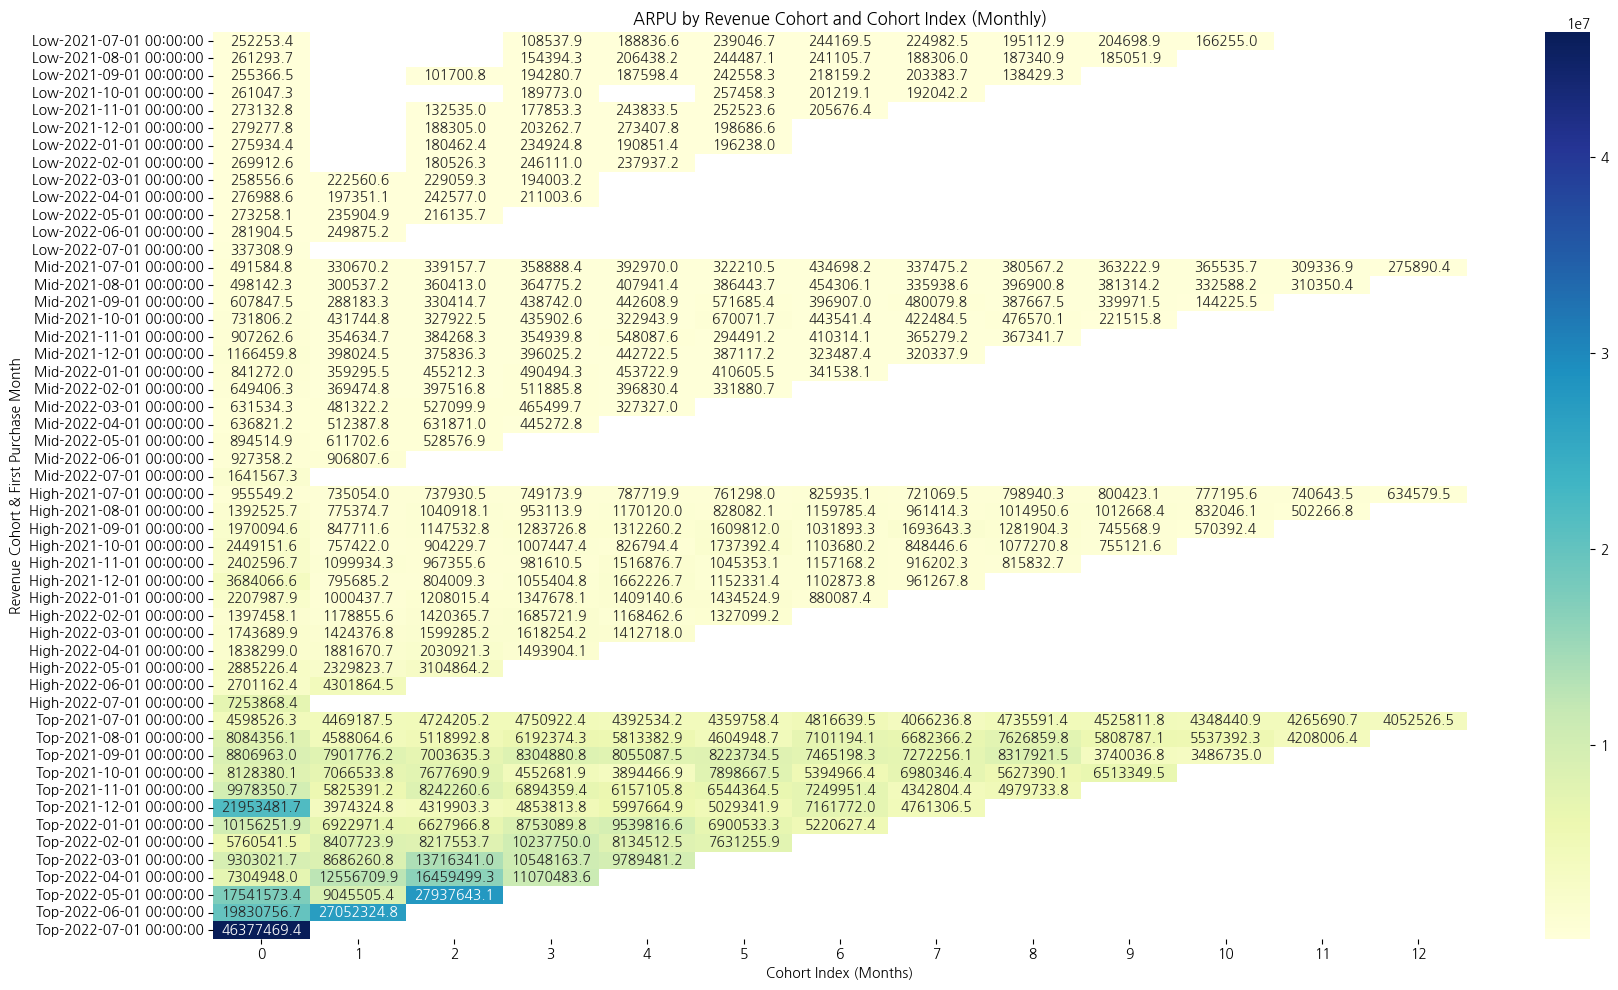

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ARPU 결과를 정리한 데이터프레임 (예: arpu_result) 기준
plt.figure(figsize=(18, 10))
sns.heatmap(arpu_result, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("ARPU by Revenue Cohort and Cohort Index (Monthly)")
plt.xlabel("Cohort Index (Months)")
plt.ylabel("Revenue Cohort & First Purchase Month")
plt.tight_layout()
plt.show()


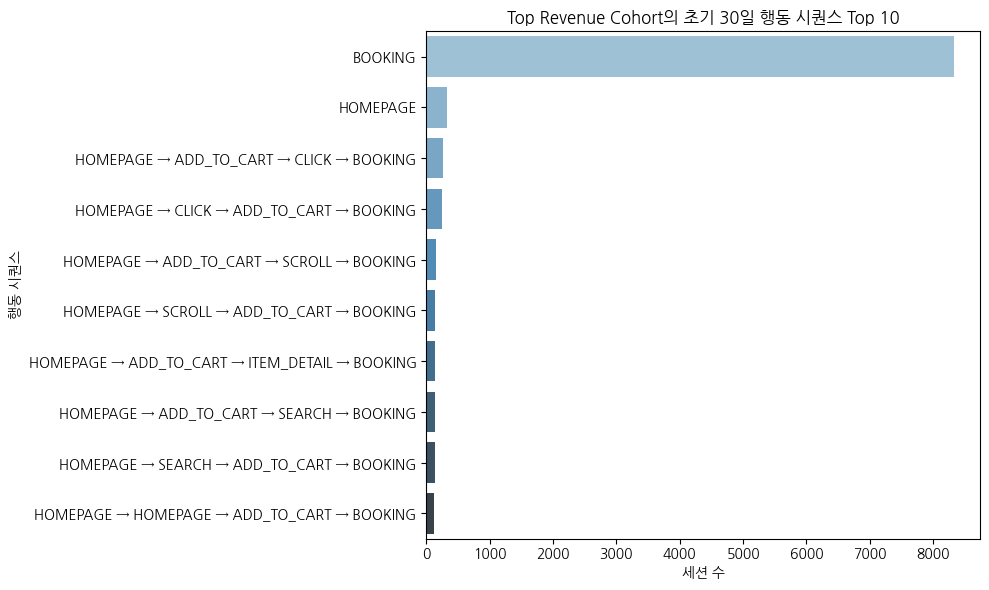

In [ ]:


# STEP 3. 고객별 첫 구매일 + 총매출 계산
customer_revenue = transaction_df.groupby('customer_id').agg(
    first_purchase_date=('created_at', 'min'),
    first_total_amount=('total_amount', 'sum')
).reset_index()

# STEP 4. 수익 기준 상위 25% 고객 선정 (Top Revenue Cohort)
threshold = customer_revenue['first_total_amount'].quantile(0.75)
top_customers = customer_revenue[customer_revenue['first_total_amount'] >= threshold]

# STEP 5. Top 고객의 세션만 필터링
top_sessions = transaction_df[transaction_df['customer_id'].isin(top_customers['customer_id'])]['session_id'].unique()

# ✅ 변수명 수정: click_df → click_stream_df
top_clicks = click_stream_df[click_stream_df['session_id'].isin(top_sessions)].copy()

# STEP 6. 첫 구매일 맵핑 (고객 기준)
customer_date_map = top_customers.set_index('customer_id')['first_purchase_date'].to_dict()
session_customer_map = transaction_df.set_index('session_id')['customer_id'].to_dict()

top_clicks['customer_id'] = top_clicks['session_id'].map(session_customer_map)
top_clicks['first_purchase_date'] = top_clicks['customer_id'].map(customer_date_map)
top_clicks['days_since_first_purchase'] = (top_clicks['event_time'] - top_clicks['first_purchase_date']).dt.days

# STEP 7. Day 0~30 행동만 추출
top_clicks_30 = top_clicks[(top_clicks['days_since_first_purchase'] >= 0) &
                           (top_clicks['days_since_first_purchase'] <= 30)]

# STEP 8. 세션별 행동 시퀀스 만들기
def get_event_sequence(df):
    return ' → '.join(df.sort_values(by='event_time')['event_name'].tolist())

event_sequence_df = top_clicks_30.groupby('session_id').apply(get_event_sequence).reset_index()
event_sequence_df.columns = ['session_id', 'event_sequence']

# STEP 9. 시퀀스 상위 10개 시각화
sequence_counts = event_sequence_df['event_sequence'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=sequence_counts.values, y=sequence_counts.index, palette='Blues_d')
plt.xlabel('세션 수')
plt.ylabel('행동 시퀀스')
plt.title('Top Revenue Cohort의 초기 30일 행동 시퀀스 Top 10')
plt.tight_layout()
plt.show()


In [ ]:
# 전환된 세션: BOOKING 이벤트가 있는 세션
converted_sessions = click_stream_df[click_stream_df['event_name'] == 'BOOKING']['session_id'].unique()

# 전환 안 된 세션: BOOKING이 없는 세션
all_sessions = click_stream_df['session_id'].unique()
non_converted_sessions = list(set(all_sessions) - set(converted_sessions))


In [ ]:
# session_id 기준으로 고객 ID를 click_df에 붙이기
click_stream_df = click_stream_df.merge(
    transaction_df[['session_id', 'customer_id']],
    on='session_id',
    how='left'
)


In [ ]:
# Top 고객의 세션만 필터링
top_sessions_all = click_stream_df[click_stream_df['customer_id'].isin(top_customers['customer_id'])]['session_id'].unique()

# 이 중 BOOKING 없는 세션만 선택
top_non_converted_sessions = list(set(top_sessions_all) & set(non_converted_sessions))

# 비전환 세션에 해당하는 클릭로그 추출
non_converted_clicks =click_stream_df[click_stream_df['session_id'].isin(top_non_converted_sessions)].copy()


In [ ]:
# 시간 순 정렬
non_converted_clicks = non_converted_clicks.sort_values(by=['session_id', 'event_time'])

# 세션별 시퀀스 생성
session_event_sequences = (
    non_converted_clicks.groupby('session_id')['event_name']
    .apply(lambda x: ' → '.join(x))
    .reset_index(name='event_sequence')
)


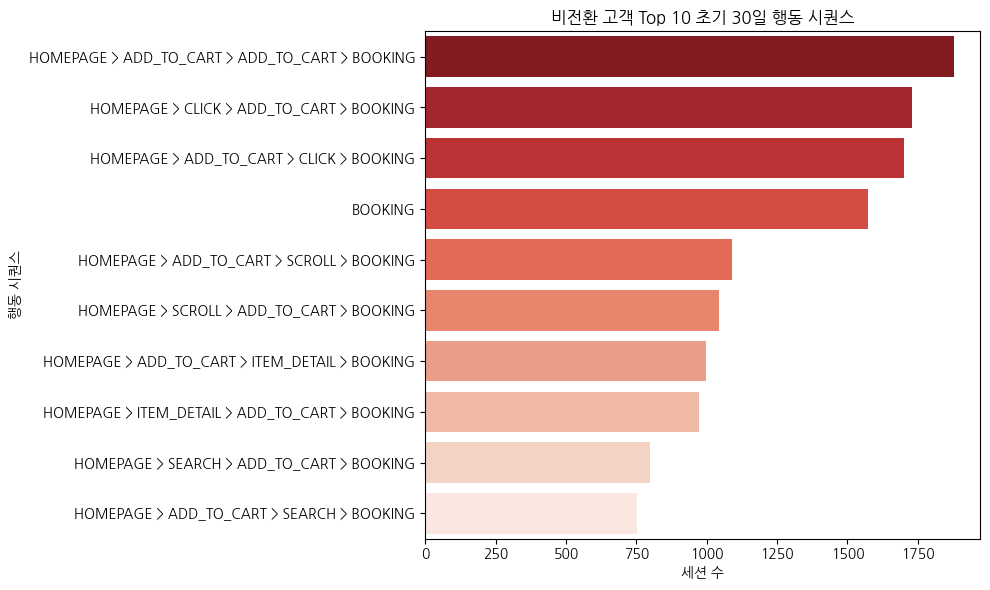

In [ ]:
# 1. 이벤트 시간 컬럼에서 날짜 추출
click_stream_df['event_date'] = click_stream_df['event_time'].dt.date

# 2. transaction_df에서 전환되지 않은 고객 ID 추출
non_buyer_ids = transaction_df[~transaction_df['customer_id'].isin(top_customers['customer_id'])]['customer_id'].unique()

# 3. 해당 고객들의 세션 추출
non_buyer_sessions = transaction_df[transaction_df['customer_id'].isin(non_buyer_ids)]['session_id'].unique()

# 4. 해당 세션에 해당하는 클릭 로그 필터링
non_top_clicks = click_stream_df[click_stream_df['session_id'].isin(non_buyer_sessions)].copy()

# 5. 첫 구매 이후 30일 이내 클릭 로그만 남기기 (전환 안 한 세션이므로 최초 클릭일 기준)
non_top_clicks['event_time'] = pd.to_datetime(non_top_clicks['event_time'])
non_top_clicks['min_event_time'] = non_top_clicks.groupby('session_id')['event_time'].transform('min')
non_top_clicks['day_since_first'] = (non_top_clicks['event_time'] - non_top_clicks['min_event_time']).dt.days
non_top_clicks_30 = non_top_clicks[non_top_clicks['day_since_first'] <= 30].copy()

# 6. 세션별 행동 시퀀스 만들기
event_seq_df = (
    non_top_clicks_30
    .sort_values(['session_id', 'event_time'])
    .groupby('session_id')['event_name']
    .apply(lambda x: ' > '.join(x))
    .reset_index()
    .rename(columns={'event_name': 'event_sequence'})
)

# 7. 시퀀스별 세션 수 집계
top_sequences = event_seq_df.groupby('event_sequence')['session_id'].nunique().reset_index()
top_sequences.columns = ['이벤트 시퀀스', '세션 수']

# 8. 상위 10개 시퀀스 추출 및 시각화
top_sequences = top_sequences.sort_values(by='세션 수', ascending=False).head(10)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=top_sequences, y='이벤트 시퀀스', x='세션 수', palette='Reds_r')
plt.title('비전환 고객 Top 10 초기 30일 행동 시퀀스')
plt.xlabel('세션 수')
plt.ylabel('행동 시퀀스')
plt.tight_layout()
plt.show()


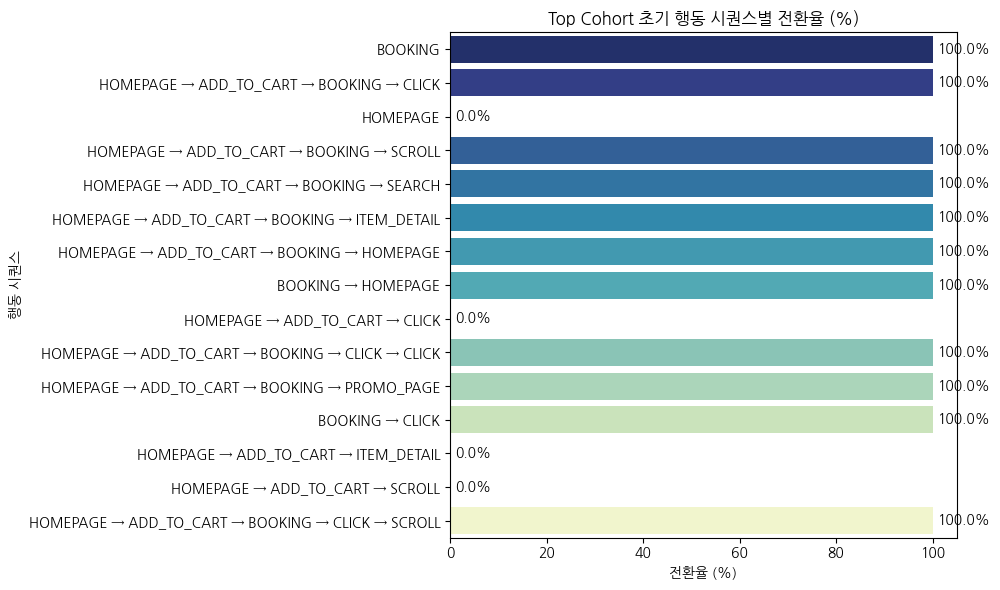

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 전환 유무가 포함된 세션-시퀀스 데이터 로드 (이미 생성한 것 활용)
# 'event_sequence', 'session_id', 'converted' 컬럼이 포함돼 있어야 함
# 예: top_clicks_30 → 'Top Cohort의 30일간 행동 데이터'

# 2. 세션 기준으로 전환 여부 확인
session_conversion = top_clicks_30.groupby('session_id')['event_name'].apply(list).reset_index()
session_conversion['event_sequence'] = session_conversion['event_name'].apply(lambda x: ' → '.join(x))
session_conversion['converted'] = session_conversion['event_name'].apply(lambda x: 'BOOKING' in x)

# 3. 시퀀스별 전환율 계산
seq_grouped = session_conversion.groupby('event_sequence').agg(
    total_sessions=('session_id', 'count'),
    conversions=('converted', 'sum')
).reset_index()

seq_grouped['conversion_rate'] = (seq_grouped['conversions'] / seq_grouped['total_sessions']) * 100

# 4. 상위 등장 시퀀스 기준 전환율 정렬
top_seq = seq_grouped.sort_values(by='total_sessions', ascending=False).head(15)



# 5. 시각화
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top_seq, x='conversion_rate', y='event_sequence', palette='YlGnBu_r')

# 수치 표시 (소수점 1자리까지 표기)
for i, (rate, total) in enumerate(zip(top_seq['conversion_rate'], top_seq['total_sessions'])):
    ax.text(rate + 1, i, f'{rate:.1f}%', va='center')

plt.title('Top Cohort 초기 행동 시퀀스별 전환율 (%)')
plt.xlabel('전환율 (%)')
plt.ylabel('행동 시퀀스')
plt.tight_layout()
plt.show()



In [ ]:

# 세션별로 30일간의 이벤트를 모아서 시퀀스 생성
click_sequences = top_clicks_30.groupby('session_id')['event_name'].apply(list).reset_index()
click_sequences.columns = ['session_id', 'event_list']

# 전환 여부 판단 (BOOKING 포함 여부)
click_sequences['converted'] = click_sequences['event_list'].apply(lambda x: 'BOOKING' in x)



In [ ]:
# BOOKING까지 자르고 이후 행동은 제거
def truncate_at_booking(event_list):
    try:
        idx = event_list.index('BOOKING')
        return " → ".join(event_list[:idx + 1])
    except ValueError:
        return " → ".join(event_list)  # BOOKING 없으면 전체 반환

# 클렌징된 시퀀스 컬럼 생성
click_sequences['clean_sequence'] = click_sequences['event_list'].apply(truncate_at_booking)


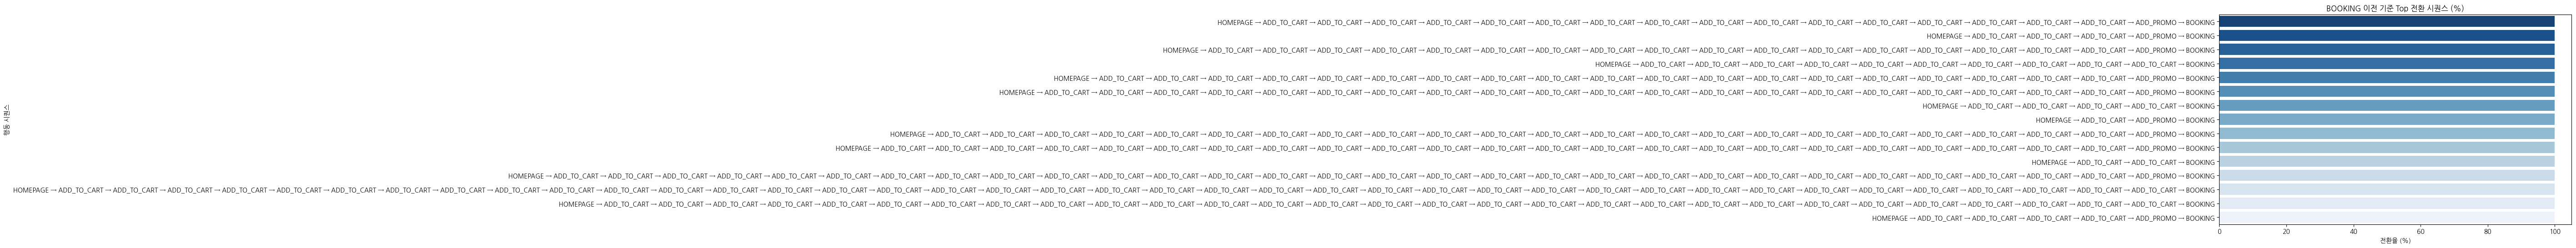

In [ ]:
# 전환율 계산
conversion_summary = click_sequences.groupby('clean_sequence').agg(
    세션수=('session_id', 'nunique'),
    전환세션수=('converted', 'sum')
).reset_index()

conversion_summary['전환율 (%)'] = round(conversion_summary['전환세션수'] / conversion_summary['세션수'] * 100, 1)

# 상위 15개 시퀀스 추출
top_converted_sequences = conversion_summary.sort_values(by='전환율 (%)', ascending=False).head(15)

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=top_converted_sequences, x='전환율 (%)', y='clean_sequence', palette='Blues_r')
plt.title('BOOKING 이전 기준 Top 전환 시퀀스 (%)')
plt.xlabel('전환율 (%)')
plt.ylabel('행동 시퀀스')
plt.tight_layout()
plt.show()


In [ ]:
# 중복 행동 제거 함수
def simplify_sequence(seq):
    seen = []
    for step in seq.split(' → '):
        if not seen or seen[-1] != step:
            seen.append(step)
    return ' → '.join(seen)

# 중복 제거 적용
click_sequences['clean_sequence_simple'] = click_sequences['clean_sequence'].apply(simplify_sequence)


In [ ]:
conversion_summary_simple = click_sequences.groupby('clean_sequence_simple').agg(
    세션수=('session_id', 'nunique'),
    전환세션수=('converted', 'sum')
).reset_index()

conversion_summary_simple['전환율 (%)'] = round(conversion_summary_simple['전환세션수'] / conversion_summary_simple['세션수'] * 100, 1)

# 상위 시퀀스 15개
top_seq_clean = conversion_summary_simple.sort_values(by='전환율 (%)', ascending=False).head(15)


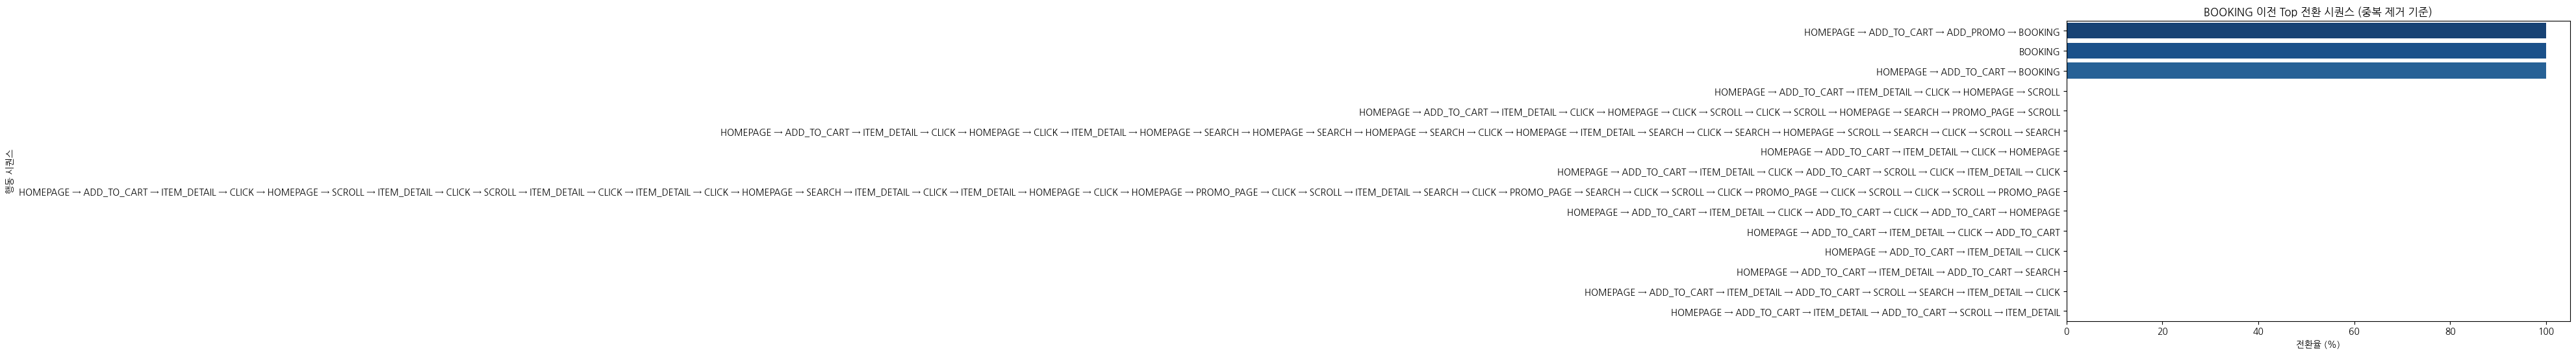

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=top_seq_clean, x='전환율 (%)', y='clean_sequence_simple', palette='Blues_r')
plt.title('BOOKING 이전 Top 전환 시퀀스 (중복 제거 기준)')
plt.xlabel('전환율 (%)')
plt.ylabel('행동 시퀀스')
plt.tight_layout()
plt.show()


In [ ]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 9.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=be718cc55a18e2d969243850cd2d170ad016eb7041c17d9d32617cb8ac0f3e3e
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


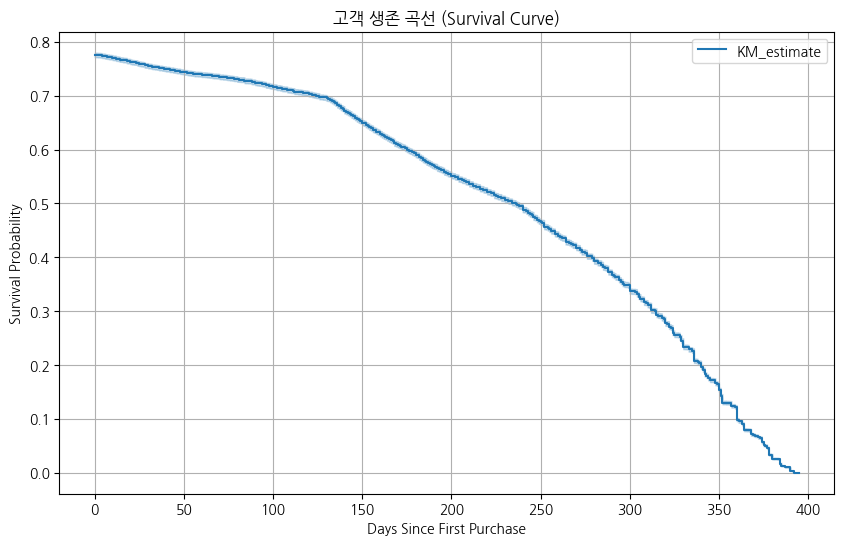

📍 Median survival time (50% 이탈 시점): 236.0일


In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import pandas as pd

# 1. 날짜 컬럼이 datetime 형식인지 확인하고 변환
transaction_df['created_at'] = pd.to_datetime(transaction_df['created_at'], utc=True)

# 2. 기준일 설정 (예: 데이터 종료 기준일로 설정)
today = transaction_df['created_at'].max() + pd.Timedelta(days=1)

# 3. 고객별 첫 구매일과 마지막 구매일 계산
cohort_df = transaction_df.groupby('customer_id').agg({
    'created_at': ['min', 'max']
}).reset_index()

cohort_df.columns = ['customer_id', 'first_purchase_date', 'last_purchase_date']

# 4. 생존 기간 및 이탈 여부 계산
cohort_df['duration'] = (cohort_df['last_purchase_date'] - cohort_df['first_purchase_date']).dt.days
cohort_df['event_observed'] = (cohort_df['last_purchase_date'] < today).astype(int)

# 5. 생존 곡선 학습 및 시각화
kmf = KaplanMeierFitter()
kmf.fit(durations=cohort_df['duration'], event_observed=cohort_df['event_observed'])

plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title("고객 생존 곡선 (Survival Curve)")
plt.xlabel("Days Since First Purchase")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

# 6. 중위 생존 시간 출력 (이탈 시점 정량화)
print(f"📍 Median survival time (50% 이탈 시점): {kmf.median_survival_time_}일")



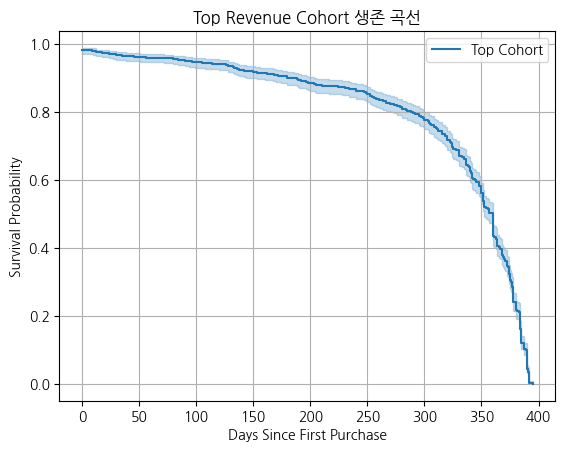

In [ ]:
# Top Cohort만 추출
top_customers = transaction_df.groupby('customer_id')['total_amount'].sum().nlargest(1000).index
top_df = transaction_df[transaction_df['customer_id'].isin(top_customers)]

# 고객별 생존기간 계산
top_survival = top_df.groupby('customer_id')['created_at'].agg(['min', 'max'])
top_survival['duration'] = (top_survival['max'] - top_survival['min']).dt.days
top_survival['event_observed'] = 1

# 생존 곡선 시각화
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(top_survival['duration'], event_observed=top_survival['event_observed'], label='Top Cohort')
kmf.plot_survival_function()
plt.title('Top Revenue Cohort 생존 곡선')
plt.xlabel('Days Since First Purchase')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()


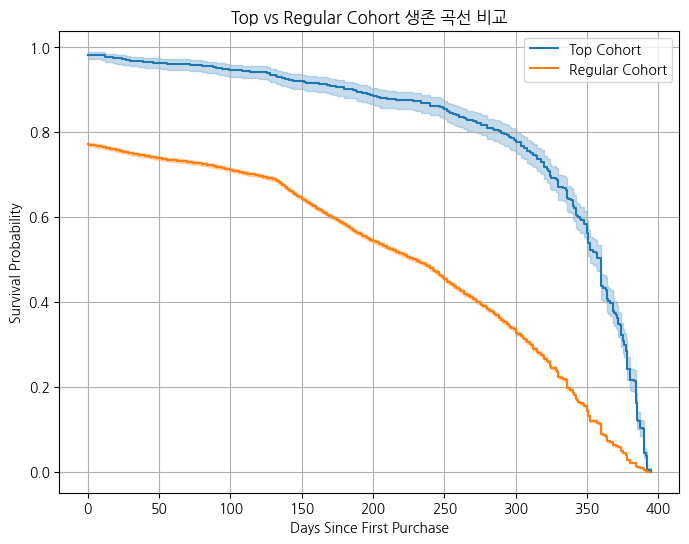

In [ ]:
# 일반 고객 추출
all_customers = set(transaction_df['customer_id'].unique())
regular_customers = all_customers - set(top_customers)
regular_df = transaction_df[transaction_df['customer_id'].isin(regular_customers)]

# 생존 곡선 데이터
reg_survival = regular_df.groupby('customer_id')['created_at'].agg(['min', 'max'])
reg_survival['duration'] = (reg_survival['max'] - reg_survival['min']).dt.days
reg_survival['event_observed'] = 1

# 두 그룹 생존 곡선 비교
kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

kmf.fit(top_survival['duration'], event_observed=top_survival['event_observed'], label='Top Cohort')
kmf.plot_survival_function()

kmf.fit(reg_survival['duration'], event_observed=reg_survival['event_observed'], label='Regular Cohort')
kmf.plot_survival_function()

plt.title('Top vs Regular Cohort 생존 곡선 비교')
plt.xlabel('Days Since First Purchase')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()


In [ ]:
!pip install lifelines


In [ ]:
df_cox = pd.DataFrame({
    'customer_id': [...],
    'duration': [...],   # 첫 구매일로부터 마지막 구매일까지의 일 수
    'event': [...],      # 재구매 여부 (1: 이탈, 0: 아직 생존)
    'total_revenue': [...],  # 누적 구매 금액
    'used_promo': [...],     # 프로모션 사용 여부 (0/1)
    'top_cohort': [...],     # Top Cohort 여부 (0: 일반, 1: Top)
    'first_month': [...]     # 첫 구매 월 (예: 1~12)
})


In [ ]:
# 1. 고객별 첫 구매일과 마지막 구매일
cohort_df = transaction_df.groupby('customer_id').agg(
    first_purchase=('created_at', 'min'),
    last_purchase=('created_at', 'max'),
    total_revenue=('total_amount', 'sum'),
    used_promo=('promo_amount', lambda x: 1 if x.sum() > 0 else 0)
).reset_index()

# 2. 분석 기준일 (최종 거래일)
analysis_date = transaction_df['created_at'].max()

# 3. duration, event 생성
cohort_df['duration'] = (cohort_df['last_purchase'] - cohort_df['first_purchase']).dt.days
cohort_df['event'] = (cohort_df['last_purchase'] < analysis_date).astype(int)

# 4. top cohort flag 추가
threshold = cohort_df['total_revenue'].quantile(0.95)
cohort_df['top_cohort'] = (cohort_df['total_revenue'] >= threshold).astype(int)

# 5. 최종 Cox 분석용 df
df_cox = cohort_df[['duration', 'event', 'total_revenue', 'used_promo', 'top_cohort']]


In [ ]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(df_cox, duration_col='duration', event_col='event')
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 39149 total observations, 1 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 39149
number of events observed = 39148
   partial log-likelihood = -366115.40
         time fit was run = 2025-07-04 17:01:17 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
total_revenue -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
used_promo    -1.26      0.28      0.01           -1.29           -1.24                0.28                0.29
top_cohort     1.29      3.65      0.04            1.22            1.37                3.38                3.94

               cmp to      z      p  -log2(p)
covariate                                    
total_revenue    0.00 -59.79 <0.005       inf
used_promo       0.00 -96.96 <0.005       inf
top_cohort       0.00  32.77 <0.005    780.02
---
Concordance = 0.79
Partial AIC = 732236.79
log-likelihood ratio test = 17474.52 on 3 df
-log2(p) of ll-ratio test = inf

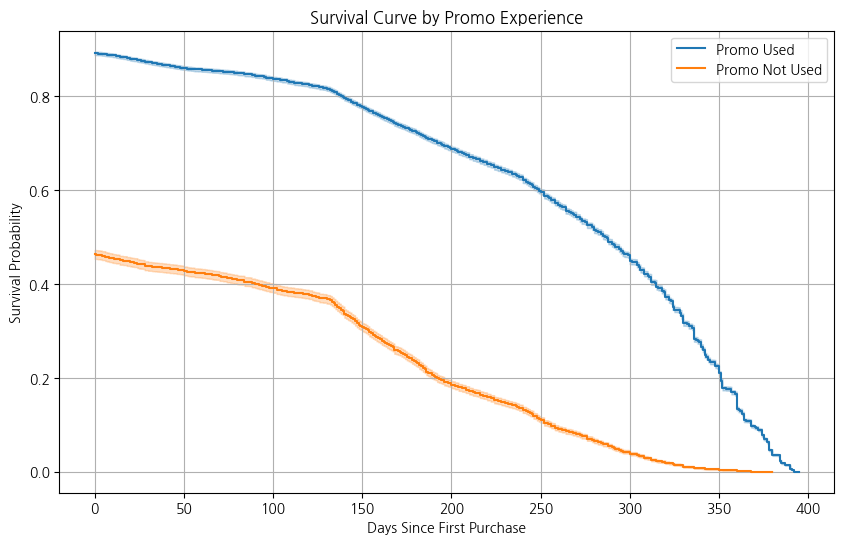

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# 생존분석 객체
kmf = KaplanMeierFitter()

# PROMO 사용 그룹과 미사용 그룹 분리
promo_group = df_cox[df_cox['used_promo'] == 1]
non_promo_group = df_cox[df_cox['used_promo'] == 0]

plt.figure(figsize=(10, 6))

# Promo 사용한 그룹 생존 곡선
kmf.fit(promo_group['duration'], event_observed=promo_group['event'], label='Promo Used')
kmf.plot_survival_function()

# Promo 사용 안 한 그룹 생존 곡선
kmf.fit(non_promo_group['duration'], event_observed=non_promo_group['event'], label='Promo Not Used')
kmf.plot_survival_function()

plt.title('Survival Curve by Promo Experience')
plt.xlabel('Days Since First Purchase')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()


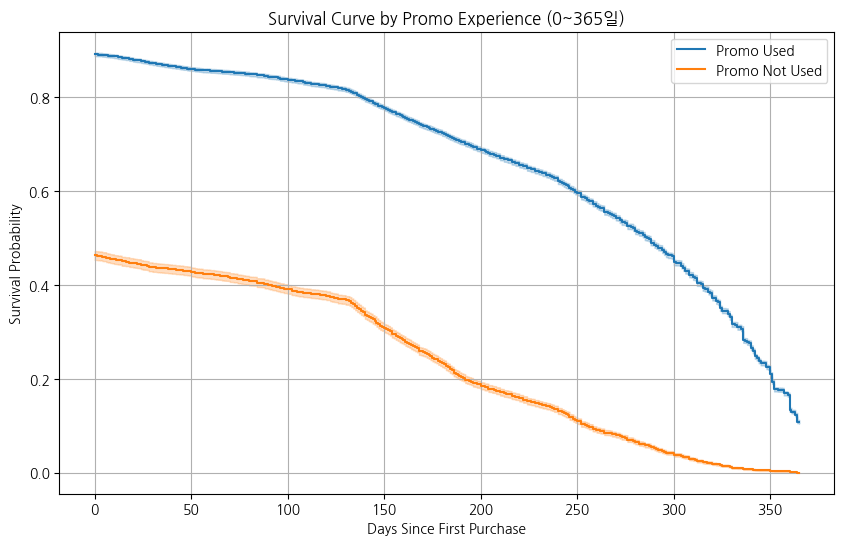

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
timeline = range(0, 366)

plt.figure(figsize=(10, 6))

# Promo Used
kmf.fit(durations=df_cox[df_cox['used_promo'] == 1]['duration'],
        event_observed=df_cox[df_cox['used_promo'] == 1]['event'],
        label='Promo Used',
        timeline=timeline)
kmf.plot_survival_function(ci_show=True)

# Promo Not Used
kmf.fit(durations=df_cox[df_cox['used_promo'] == 0]['duration'],
        event_observed=df_cox[df_cox['used_promo'] == 0]['event'],
        label='Promo Not Used',
        timeline=timeline)
kmf.plot_survival_function(ci_show=True)

plt.title('Survival Curve by Promo Experience (0~365일)')
plt.xlabel('Days Since First Purchase')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()



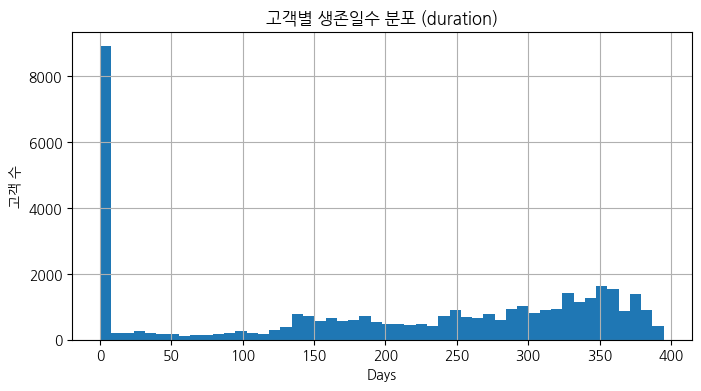

In [ ]:
plt.figure(figsize=(8, 4))
df_cox['duration'].hist(bins=50)
plt.title('고객별 생존일수 분포 (duration)')
plt.xlabel('Days')
plt.ylabel('고객 수')
plt.grid(True)
plt.show()


In [ ]:
df_cox[['duration', 'event']].isnull().sum()


,0
duration,0
event,0


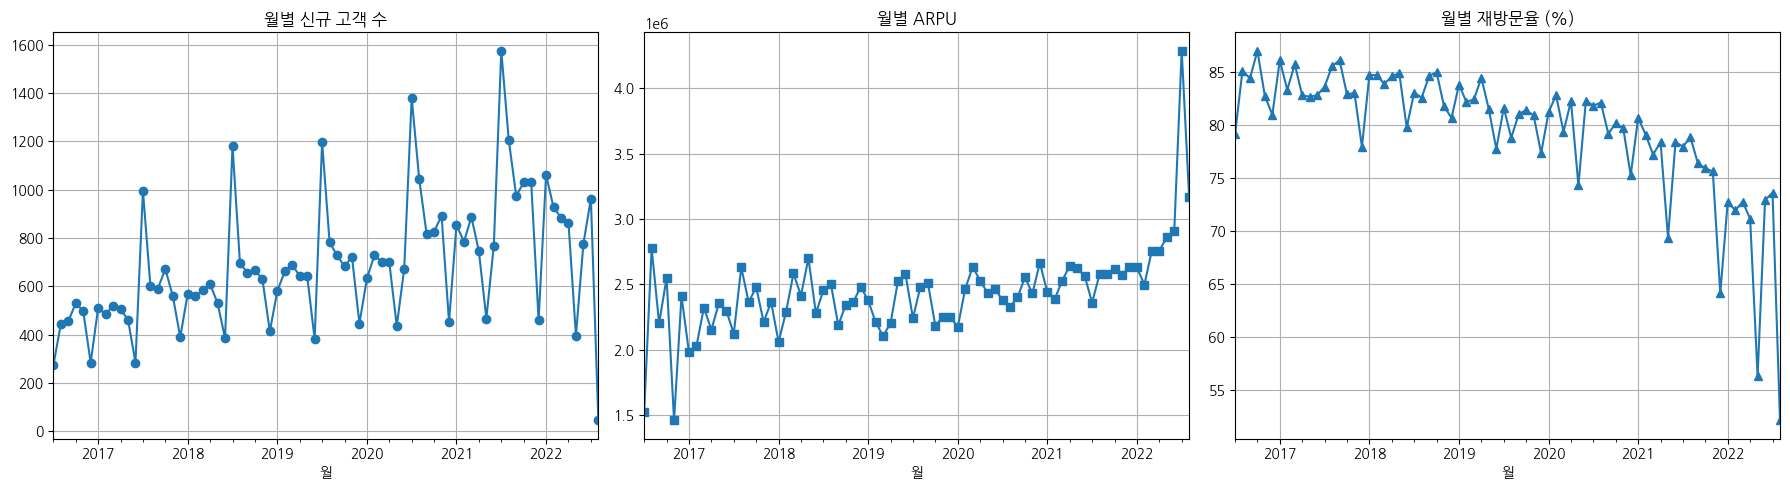

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
transaction_df = pd.read_csv('/content/drive/MyDrive/Commerce/transactions_cleaned.csv', parse_dates=['created_at'])
transaction_df['created_at'] = transaction_df['created_at'].dt.tz_convert('Asia/Jakarta')

# 1. 월별 유입 고객 수 (첫 구매 기준)
transaction_df['first_purchase'] = transaction_df.groupby('customer_id')['created_at'].transform('min')
transaction_df['first_purchase_month'] = transaction_df['first_purchase'].dt.to_period('M').dt.to_timestamp()

monthly_new_users = transaction_df.drop_duplicates('customer_id').groupby('first_purchase_month')['customer_id'].count()

# 2. 월별 ARPU (월 총매출 / 월별 구매 고객 수)
transaction_df['order_month'] = transaction_df['created_at'].dt.to_period('M').dt.to_timestamp()
monthly_arpu = transaction_df.groupby('order_month')['total_amount'].sum() / transaction_df.groupby('order_month')['customer_id'].nunique()

# 3. 월별 재방문율 (2회 이상 구매한 고객 비율)
customer_order_count = transaction_df.groupby('customer_id')['booking_id'].nunique()
repeat_customers = customer_order_count[customer_order_count > 1].index

transaction_df['is_repeat'] = transaction_df['customer_id'].isin(repeat_customers)
monthly_repeat_rate = transaction_df.drop_duplicates('customer_id').groupby('first_purchase_month')['is_repeat'].mean() * 100

# 시각화
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
monthly_new_users.plot(ax=axs[0], marker='o', title='월별 신규 고객 수')
monthly_arpu.plot(ax=axs[1], marker='s', title='월별 ARPU')
monthly_repeat_rate.plot(ax=axs[2], marker='^', title='월별 재방문율 (%)')

for ax in axs:
    ax.set_xlabel('월')
    ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# 1. 월별 신규 고객 수
transaction_df['first_purchase'] = transaction_df.groupby('customer_id')['created_at'].transform('min')
transaction_df['first_purchase_month'] = transaction_df['first_purchase'].dt.to_period('M').dt.to_timestamp()
monthly_new_users = transaction_df.drop_duplicates('customer_id').groupby('first_purchase_month')['customer_id'].count().reset_index()
monthly_new_users.columns = ['month', 'new_users']

# 2. 월별 ARPU
transaction_df['order_month'] = transaction_df['created_at'].dt.to_period('M').dt.to_timestamp()
monthly_sales = transaction_df.groupby('order_month')['total_amount'].sum()
monthly_users = transaction_df.groupby('order_month')['customer_id'].nunique()
monthly_arpu = (monthly_sales / monthly_users).reset_index()
monthly_arpu.columns = ['month', 'ARPU']

# 3. 월별 재방문율
customer_order_count = transaction_df.groupby('customer_id')['booking_id'].nunique()
repeat_customers = customer_order_count[customer_order_count > 1].index
transaction_df['is_repeat'] = transaction_df['customer_id'].isin(repeat_customers)
monthly_repeat_rate = transaction_df.drop_duplicates('customer_id').groupby('first_purchase_month')['is_repeat'].mean().reset_index()
monthly_repeat_rate.columns = ['month', 'repeat_rate']

# 병합
overview_df = monthly_new_users.merge(monthly_arpu, on='month').merge(monthly_repeat_rate, on='month')

# 저장
overview_df.to_csv('/content/drive/MyDrive/Commerce/overview_kpi.csv', index=False)


In [ ]:
print(cohort_pivot.columns)


Index(['revenue_cohort', 'cohort_month', 'cohort_index', 'customer_id'], dtype='object')


In [ ]:
# 주차 기준으로 변환
transaction_df['created_week'] = transaction_df['created_at'].dt.to_period('W').dt.to_timestamp()
first_week_df = transaction_df.groupby('customer_id')['created_week'].min().reset_index()
first_week_df.columns = ['customer_id', 'cohort_week']

# 병합
transaction_df = transaction_df.merge(first_week_df, on='customer_id')

# 주차 Cohort Index
transaction_df['cohort_week_index'] = (
    (transaction_df['created_week'] - transaction_df['cohort_week']) / pd.Timedelta(weeks=1)
).round().astype('int') + 1

# 주차 리텐션 테이블
weekly_pivot = transaction_df.groupby(['cohort_week', 'cohort_week_index'])['customer_id'].nunique().reset_index()
weekly_pivot = weekly_pivot.pivot(index='cohort_week', columns='cohort_week_index', values='customer_id')

# 비율
weekly_size = weekly_pivot[1]
weekly_retention = weekly_pivot.divide(weekly_size, axis=0).round(3)

# CSV 저장
weekly_retention.reset_index().to_csv('/content/drive/MyDrive/Commerce/weekly_retention.csv', index=False)


In [ ]:
print(transaction_df.columns)

Index(['created_at', 'customer_id', 'booking_id', 'session_id',
       'payment_method', 'payment_status', 'promo_amount', 'promo_code',
       'shipment_fee', 'shipment_date_limit', 'shipment_location_lat',
       'shipment_location_long', 'total_amount', 'product_id', 'quantity',
       'item_price', 'first_purchase', 'first_purchase_month', 'order_month',
       'is_repeat', 'cohort_month', 'cohort_index', 'created_week',
       'cohort_week', 'cohort_week_index'],
      dtype='object')


In [ ]:
print(transaction_df.columns)  # 전체 확인
print('total_amount' in transaction_df.columns)  # 정확한 존재 여부
transaction_df[['customer_id', 'total_amount']].head()  # 오류 재현 여부 확인



Index(['created_at', 'customer_id', 'booking_id', 'session_id',
       'payment_method', 'payment_status', 'promo_amount', 'promo_code',
       'shipment_fee', 'shipment_date_limit', 'shipment_location_lat',
       'shipment_location_long', 'total_amount', 'product_id', 'quantity',
       'item_price', 'first_purchase', 'first_purchase_month', 'order_month',
       'is_repeat', 'cohort_month', 'cohort_index', 'created_week',
       'cohort_week', 'cohort_week_index'],
      dtype='object')
True


,customer_id,total_amount
0,5868,199832
1,4774,155526
2,4774,550696
3,4774,271012
4,4774,198753


In [ ]:
first_purchase = transaction_df.groupby('customer_id').agg(
    first_purchase_date=('created_at', 'min'),
    first_total_amount=('total_amount', 'sum')
).reset_index()

In [ ]:
print(transaction_df.columns.tolist())


['created_at', 'customer_id', 'booking_id', 'session_id', 'payment_method', 'payment_status', 'promo_amount', 'promo_code', 'shipment_fee', 'shipment_date_limit', 'shipment_location_lat', 'shipment_location_long', 'total_amount', 'product_id', 'quantity', 'item_price', 'first_purchase', 'first_purchase_month', 'order_month', 'is_repeat', 'cohort_month', 'cohort_index', 'created_week', 'cohort_week', 'cohort_week_index']


In [ ]:
# 고객별 총 매출 및 첫 구매일
revenue_summary = transaction_df.groupby('customer_id').agg(
    first_purchase=('created_at', 'min'),
    last_purchase=('created_at', 'max'),
    total_revenue=('total_amount', 'sum')
).reset_index()

# duration, event(이탈 여부) 생성
analysis_date = transaction_df['created_at'].max()
revenue_summary['duration'] = (revenue_summary['last_purchase'] - revenue_summary['first_purchase']).dt.days
revenue_summary['event'] = (revenue_summary['last_purchase'] < analysis_date).astype(int)

# 4분위 revenue_cohort 부여
revenue_summary['revenue_cohort'] = pd.qcut(
    revenue_summary['total_revenue'],
    q=4,
    labels=['Low', 'Mid', 'High', 'Top']
)

# 저장
revenue_summary[['customer_id', 'duration', 'event', 'revenue_cohort']] \
    .to_csv('/content/drive/MyDrive/Commerce/revenue_survival.csv', index=False)


In [ ]:
# 기본 정보 정리
transaction_df['created_at'] = pd.to_datetime(transaction_df['created_at'], utc=True)
analysis_date = transaction_df['created_at'].max() + pd.Timedelta(days=1)

# 고객별 구매 기간 정보
cohort_df = transaction_df.groupby('customer_id').agg(
    first_purchase=('created_at', 'min'),
    last_purchase=('created_at', 'max'),
    total_revenue=('total_amount', 'sum'),
    used_promo=('promo_amount', lambda x: 1 if x.sum() > 0 else 0)
).reset_index()

# 생존 분석에 필요한 변수 추가
cohort_df['duration'] = (cohort_df['last_purchase'] - cohort_df['first_purchase']).dt.days
cohort_df['event'] = (cohort_df['last_purchase'] < analysis_date).astype(int)

# Top Cohort flag (상위 5%)
revenue_threshold = cohort_df['total_revenue'].quantile(0.95)
cohort_df['top_cohort'] = (cohort_df['total_revenue'] >= revenue_threshold).astype(int)

# ➕ 월 정보도 추가 (선택사항)
cohort_df['first_purchase_month'] = cohort_df['first_purchase'].dt.to_period("M").astype(str)


In [ ]:
cohort_df.to_csv('/content/drive/MyDrive/Commerce/survival_analysis_data.csv', index=False)


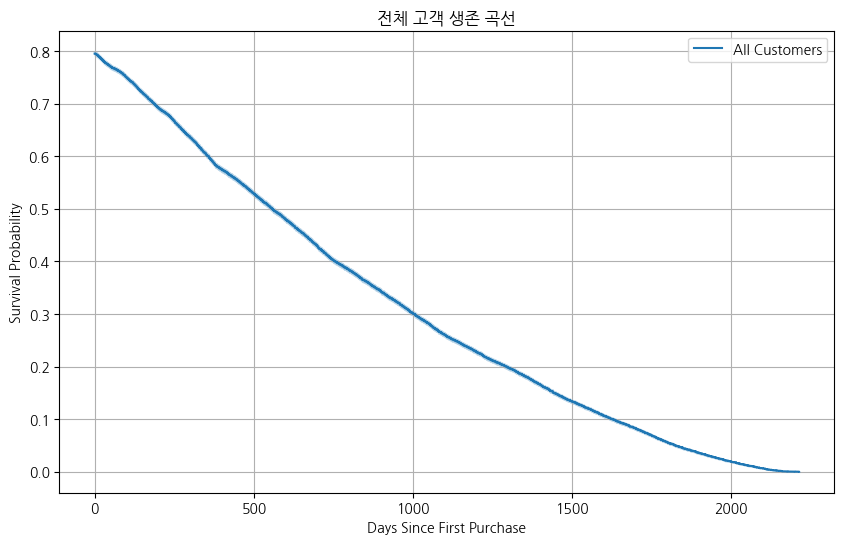

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# 전체 생존곡선
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))
kmf.fit(durations=cohort_df['duration'], event_observed=cohort_df['event'], label='All Customers')
kmf.plot_survival_function()
plt.title('전체 고객 생존 곡선')
plt.xlabel('Days Since First Purchase')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()


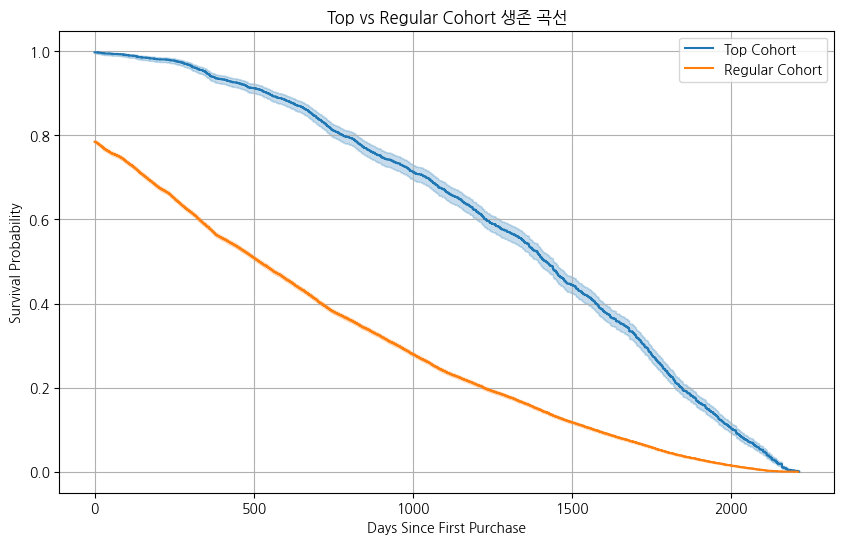

In [ ]:
plt.figure(figsize=(10, 6))

# Top Cohort
kmf.fit(cohort_df[cohort_df['top_cohort'] == 1]['duration'],
        cohort_df[cohort_df['top_cohort'] == 1]['event'],
        label='Top Cohort')
kmf.plot_survival_function()

# 일반 Cohort
kmf.fit(cohort_df[cohort_df['top_cohort'] == 0]['duration'],
        cohort_df[cohort_df['top_cohort'] == 0]['event'],
        label='Regular Cohort')
kmf.plot_survival_function()

plt.title('Top vs Regular Cohort 생존 곡선')
plt.xlabel('Days Since First Purchase')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()


In [ ]:
from lifelines import CoxPHFitter

df_cox = cohort_df[['duration', 'event', 'total_revenue', 'used_promo', 'top_cohort']].copy()
cph = CoxPHFitter()
cph.fit(df_cox, duration_col='duration', event_col='event')
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 50705 total observations, 0 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 50705
number of events observed = 50705
   partial log-likelihood = -489833.45
         time fit was run = 2025-07-04 15:03:55 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
total_revenue -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
used_promo    -1.30      0.27      0.01           -1.32           -1.28                0.27                0.28
top_cohort     0.65      1.91      0.03            0.58            0.71                1.79                2.04

               cmp to       z      p  -log2(p)
covariate                                     
total_revenue    0.00  -46.61 <0.005       inf
used_promo       0.00 -110.46 <0.005       inf
top_cohort       0.00   19.29 <0.005    272.89
---
Concordance = 0.74
Partial AIC = 979672.91
log-likelihood ratio test = 17589.38 on 3 df
-log2(p) of ll-ratio test = inf

In [ ]:
df_cox.to_csv('/content/drive/MyDrive/Commerce/cox_model_data.csv', index=False)


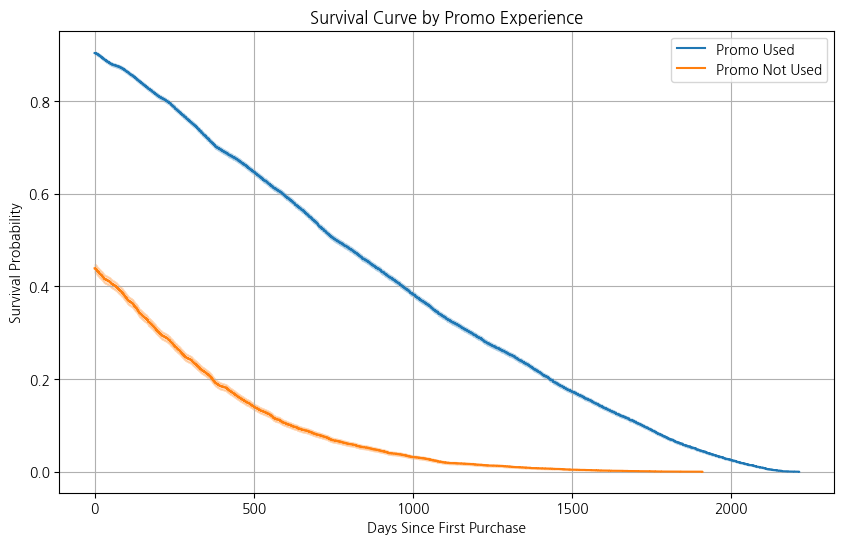

In [ ]:
plt.figure(figsize=(10, 6))

# Promo 사용
kmf.fit(cohort_df[cohort_df['used_promo'] == 1]['duration'],
        event_observed=cohort_df[cohort_df['used_promo'] == 1]['event'],
        label='Promo Used')
kmf.plot_survival_function()

# Promo 미사용
kmf.fit(cohort_df[cohort_df['used_promo'] == 0]['duration'],
        event_observed=cohort_df[cohort_df['used_promo'] == 0]['event'],
        label='Promo Not Used')
kmf.plot_survival_function()

plt.title('Survival Curve by Promo Experience')
plt.xlabel('Days Since First Purchase')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()
